In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
#unpack our learning dataset
words = open('names.txt','r').read().splitlines()
words[:6]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte']

In [ ]:
#Vocabulary of characters an mappings from/to integers

chars = sorted(list(set(''.join(words)))) # concatenate all dataset as a sinle string and passes it thru the set constructor

stoi = {s:i+1 for i,s in enumerate(chars)} # stoi maps a-0, b-1 and so on til z-25

# what about ourspecial char
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
block_size = 3 # context length: how many char do we take to predict the next one
X, Y = [], [] #X are input to the NN and Y are the label for each example inside X
for w in words[:]: #rn first 5 for efficeincy
  #print(w) 
  context = [0] * block_size # padded context of 0 tokens
  for ch in w + '.':
     ix = stoi[ch]     
     X.append(context) # stores the current running context context 
     Y.append(ix) # array y of the current character 
     context = context[1:] + [ix] # crop the context and append new char in sequence

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
X.shape, Y.shape #dataset

(torch.Size([228146, 3]), torch.Size([228146]))

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,2), generator=g)
W1 = torch.randn((6, 100), generator=g) # lets have 100 neurons
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100,27), generator=g) # input is now 100, output 27 cause 27 chars
b2 = torch.randn(27, generator=g)

# make a single list of the parameters
param = [C,W1,b1,W2,b2]

In [ ]:
sum(p.nelement() for p in param) #number of total parameters stays same

3481

In [ ]:
#they all require gradients
for p in param:
  p.requires_grad = True


In [ ]:
for i in range(500):

  #minibatch creation
  ix = torch.randint(0,X.shape[0], (32,)) #creating integers to index into our dataset (32 of them)
# as we are only dealing with minibatches the quality of our gradient isn't the best, but the grad direction is good enough that it is useful
# the point is that it is BETTER to have an approx gradient and take a lot of steps rather than calculating the EXACT gradient and having fewer steps

  #forward pass
  emb = C[X[ix]] # allows our embedding to be 32,3,2 not 22000,3,2
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())

  #backward pass
  for p in param:
    p.grad = None
  loss.backward()

  #update
  for p in param:
    p.data += -0.1 * p.grad #0.1 learning rate for now



rn its taking quite some time for every single interation. we are forwarding and bacwarding 28000 example. its faster if we do this in batches. thus we select a random minibatch and forward, backward and update on this minibatch and then do this for all the minibatches 

In [ ]:
# torch.randint(0,X.shape[0], (32,)) #creating integers to index into our dataset (32 of them)

HOW does one figure out what learning rate we want. From playing around with the function a good rate is somewhere between 0.001 and 1 for our dataset. lets find it

In [ ]:
lre = torch.linspace(-3,0,1000) # because we dont wanna go thru all of these linearly
lrs = 10**lre # now we are spaced exponentially in the interval
#lrs

In [ ]:
#lets track the learning rate and losses

lri = []
lossi = []

for i in range(10000):

  #minibatch creation
  ix = torch.randint(0,X.shape[0], (32,)) #creating integers to index into our dataset (32 of them)
# as we are only dealing with minibatches the quality of our gradient isn't the best, but the grad direction is good enough that it is useful
# the point is that it is BETTER to have an approx gradient and take a lot of steps rather than calculating the EXACT gradient and having fewer steps

  #forward pass
  emb = C[X[ix]] # allows our embedding to be 32,3,2 not 22000,3,2
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())

  #backward pass
  for p in param:
    p.grad = None
  loss.backward()

  #update
  #lr = lrs[i]
  lr = 10**-1
  for p in param:
    p.data += -lr * p.grad #0.1 learning rate for now

  #stat tracker
  #lri.append(lre[i])
  #lossi.append(loss.item())


print(loss.item())


2.359174966812134


In [ ]:
#plt.plot(lri,lossi)

emb = C[X[ix]] # allows our embedding to be 32,3,2 not 22000,3,2
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y[ix])
print(loss.item())

1.9533624649047852


NOTE: this is not the best model, because if we lets say added a lot more neurons and overfit the data cause of more params, it will become more of a copy machine as in it will simply memorise the dataset verbatum and not produce any new words. THUS, we split the dataset into three as follows.

## Training split(80%), dev/validation (10%), test(10%)
remember that test split is only used a handfull of times otherwise the NN will get trained on that too. 

In [ ]:
# building the dataset

def build_dataset(words):
    block_size = 3 # context length: how many char do we take to predict the next one
    X, Y = [], [] #X are input to the NN and Y are the label for each example inside X
    for w in words[:]: #rn first 5 for efficeincy
      #print(w) 
      context = [0] * block_size # padded context of 0 tokens
      for ch in w + '.':
        ix = stoi[ch]     
        X.append(context) # stores the current running context context 
        Y.append(ix) # array y of the current character 
        context = context[1:] + [ix] # crop the context and append new char in sequence

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1]) #80% of the words
Xdev, Ydev = build_dataset(words[n1:n2])# 90 -80% of the words
Xte, Yte = build_dataset(words[n2:])# remaining words

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Training Dataset

In [ ]:
Xtr.shape, Ytr.shape #dataset

(torch.Size([182625, 3]), torch.Size([182625]))

reset the netwrk

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30, 300), generator=g) # lets have 100 neurons
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300,27), generator=g) # input is now 100, output 27 cause 27 chars
b2 = torch.randn(27, generator=g)

# make a single list of the parameters
param = [C,W1,b1,W2,b2]

print(sum(p.nelement() for p in param)) #number of total parameters stays same


#they all require gradients
for p in param:
  p.requires_grad = True

17697


In [ ]:
lre = torch.linspace(-3,0,1000) # because we dont wanna go thru all of these linearly
lrs = 10**lre # now we are spaced exponentially in the interval

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:

for i in range(100000):

  #minibatch creation
  ix = torch.randint(0,Xtr.shape[0], (42,)) #creating integers to index into our dataset (32 of them)

  #forward pass
  emb = C[Xtr[ix]] # allows our embedding to be 32,3,2 not 22000,3,2
  h = torch.tanh(emb.view(-1,30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  #backward pass
  for p in param:
    p.grad = None
  loss.backward()

  #update
  #lr = lrs[i]
  lr = 0.1 if i<50000 else 0.01
  for p in param:
    p.data += -lr * p.grad #0.1 learning rate for now

  #stat tracker
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())



print(loss.item())

2.0840373039245605


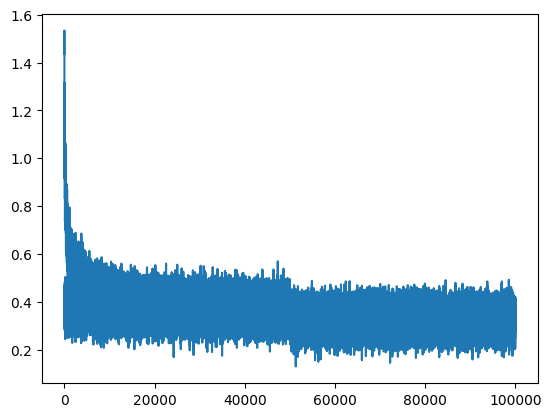

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.112736225128174


In [ ]:
emb = C[Xdev] 
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.168076753616333


the training and dev losses are about the same. this implies we are underfiitng our data. Need more parameters in our NN. lets go back and scale up.

we scaled up thehidden layer but the embbedings may be causing a bottleneck. this culd be due to use only embedding over 2 dimensions, and the data is too much to embedd of sucha a small dimension.lets try increasing the size to 10 dim. Note: refer to the MLP character NN video by anderj kaparthy at (1:04:35)

# Sample 

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)


for i in range(30):
  out = []
  context = [0] * block_size
  while True:
    
    emb = C[torch.tensor([context])] 
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]

    out.append(ix)
    #print(itos[ix])
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

mora.
kayanniee.
mad.
ryah.
rethan.
endram.
caileed.
eliah.
milopileigh.
esmanaraelyzion.
kamin.
shuberg.
himies.
kindreelynn.
nochif.
uzzingel.
kymoni.
els.
kayshaston.
azhia.
calynn.
ufe.
alel.
juren.
crevis.
evonten.
adi.
fen.
oeshan.
peigh.
